$$\Large \color{green}{\textbf{Kaggle Project On Detecting The Toxic Comments }}$$

$$\small \color{blue}{\textbf{The CopyRight @ Phuong Van Nguyen}}$$
$$\small \color{red}{\textbf{ phuong.nguyen@summer.barcelonagse.eu}}$$

This Machine Learning program was wrotten by Phuong V. Nguyen, based on the Anacoda 1.9.7 and Python 3.7.

$$\small \color{blue}{\underline{\textbf{Issue:}}}$$

You’re challenged to build a multi-headed model that’s capable of detecting different types of of toxicity like threats, obscenity, insults, and identity-based hate better than Perspective’s current models. You’ll be using a dataset of comments from Wikipedia’s talk page edits. Improvements to the cur. For further information, One can refer to the overview of this problem in the following link

https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/overview


# Loading the necessary libraries



In [81]:
import os
from time import time
import numpy as np
import pandas as pd
from scipy import stats
from pandas import set_option
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [2]:
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [65]:
from sklearn.utils.extmath import density
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2

In [4]:
Purple= '\033[95m'
Cyan= '\033[96m'
Darkcyan= '\033[36m'
Blue = '\033[94m'
Green = '\033[92m'
Yellow = '\033[93m'
Red = '\033[91m'
Bold = "\033[1m"
Reset = "\033[0;0m"
Underline= '\033[4m'
End = '\033[0m'

# Loading data

In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
subm = pd.read_csv('sample_submission.csv')

# Exploratory Data Analysis (EDA)

The training data contains a row per comment, with an id, the text of the comment, and 6 different labels that we'll try to predict.
## Picking sample

In [6]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


Here's a couple of examples of comments, one toxic, and one with no labels.

In [7]:
train['comment_text'][0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [8]:
train['comment_text'][2]

"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info."

## Checking the size

In [9]:
print('The size of the train data:')
print(train.shape)
print('The size of the test data:')
print(test.shape)

The size of the train data:
(159571, 8)
The size of the test data:
(153164, 2)


In [13]:
print('The size of the train data:'+End)
print('The number of comments: %d. The number of columns: %d'%(train.shape))
print('The size of the test data:')
print('The number of comments: %d. The number of columns: %d'%(test.shape))

The size of the train data:
The number of comments: 159571. The number of columns: 8
The size of the test data:
The number of comments: 153164. The number of columns: 2


## Checking name of feature

In [14]:
print('The name of %d features in the train data:'%(len(train.columns)))
print(train.columns)
print('The name of %d features in the test data:'%(len(test.columns)))
print(test.columns)

The name of 8 features in the train data:
Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')
The name of 2 features in the test data:
Index(['id', 'comment_text'], dtype='object')


## Distribution of the length of the comments
The length of the comments varies a lot.

In [15]:
lens = train.comment_text.str.len()
print('The distribution of the length of comments:')
print('Mean: %.2f; Standard Diviation: %.2f; Max: %d'%(lens.mean(), lens.std(), lens.max()))


The distribution of the length of comments:
Mean: 394.07; Standard Diviation: 590.72; Max: 5000


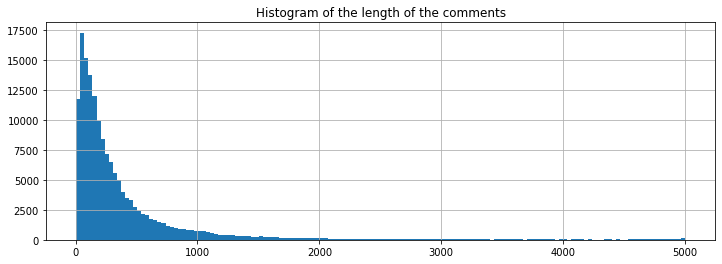

In [16]:
plt.figure(figsize=(12, 4))
lens.hist(bins=150,density=False);
plt.title("Histogram of the length of the comments")
plt.show()

## Checking missing data

In [17]:
print('Missing value in the training data:')
print(train.isnull().sum())
print('Missing value in the test data:')
print(test.isnull().sum())

Missing value in the training data:
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64
Missing value in the test data:
id              0
comment_text    0
dtype: int64


## Creating an additional label

We do this because we can see how many comments have no labels. 


In [18]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train['none'] = 1-train[label_cols].max(axis=1)
train.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate', 'none'],
      dtype='object')

## Descriptive statistics

In [19]:
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,none
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805,0.898321
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420,0.302226
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Fulfilling empty comments

In [20]:
COMMENT = 'comment_text'
train[COMMENT].fillna("unknown", inplace=True)
test[COMMENT].fillna("unknown", inplace=True)

# Data preparation

Our target features are the labeled comments and the explanatory variables are comments. The type of the target features are to belong to the binary variables. Thus, we need to convert our explanatory variables, here is the text-formated comments, into the numerical type. To this end, the $\textbf{Term Frequency-Inverse Document Frequency}$, well-known as $\textbf{TF-IDF}$, is typically computed.

 We'll start by creating a *bag of words* representation, as a *term document matrix*.
 
 ## Creating a bage of words

In [23]:
import re, string
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
re_tok

re.compile(r'([!"#$%&\'()*+,-./:;<=>?@[\]^_`{|}~“”¨«»®´·º½¾¿¡§£₤‘’])',
re.UNICODE)

In [24]:
def tokenize(s): 
    return re_tok.sub(r' \1 ', s).split()

We need to compute the TFIDF score for your documents, here comments. First, let's compute it manually.

## Manual

One can refer to
https://kavita-ganesan.com/tfidftransformer-tfidfvectorizer-usage-differences/#.XlcQCxMza1s
### Initialize CountVectorizer

In order to start using TfidfTransformer you will first have to create a CountVectorizer to count the number of words (term frequency), limit your vocabulary size, apply stop words and etc

In [25]:
cv=CountVectorizer()
cv

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

### Computing term of frequency

Term frequency: 

Suppose we have a set of English text documents and wish to rank which document is most relevant to the query, "the brown cow". A simple way to start out is by eliminating documents that do not contain all three words "the", "brown", and "cow", but this still leaves many documents. To further distinguish them, we might count the number of times each term occurs in each document; the number of times a term occurs in a document is called its term frequency. However, in the case where the length of documents varies greatly, adjustments are often made (see definition below)

https://en.wikipedia.org/wiki/Tf%E2%80%93idf

This steps generates word counts for the words in your docs, here is the comments

In [26]:
word_count_vector=cv.fit_transform(train[COMMENT])

In [27]:
word_count_vector

<159571x189775 sparse matrix of type '<class 'numpy.int64'>'
	with 6949691 stored elements in Compressed Sparse Row format>

In [28]:
print(word_count_vector)

  (0, 62514)	1
  (0, 181219)	1
  (0, 165439)	3
  (0, 57020)	1
  (0, 102805)	1
  (0, 172691)	1
  (0, 113373)	1
  (0, 175025)	1
  (0, 76897)	1
  (0, 107934)	1
  (0, 63803)	1
  (0, 180427)	1
  (0, 141678)	1
  (0, 166138)	1
  (0, 180436)	1
  (0, 175897)	1
  (0, 91648)	1
  (0, 39059)	1
  (0, 120889)	1
  (0, 154899)	1
  (0, 70307)	1
  (0, 12840)	1
  (0, 178394)	1
  (0, 20700)	1
  (0, 116025)	1
  :	:
  (159570, 16155)	2
  (159570, 53979)	1
  (159570, 137827)	1
  (159570, 86288)	1
  (159570, 120045)	2
  (159570, 166250)	1
  (159570, 185845)	2
  (159570, 77501)	1
  (159570, 180706)	1
  (159570, 179470)	1
  (159570, 72696)	1
  (159570, 165722)	1
  (159570, 33228)	1
  (159570, 78656)	1
  (159570, 22801)	2
  (159570, 172820)	1
  (159570, 72887)	1
  (159570, 142378)	1
  (159570, 40739)	1
  (159570, 22033)	2
  (159570, 94277)	1
  (159570, 82756)	1
  (159570, 82782)	1
  (159570, 141839)	1
  (159570, 78394)	1


Now, let’s check the shape. 

In [29]:
print('The number of comments: %d. The number of words: %d'%(word_count_vector.shape))

The number of comments: 159571. The number of words: 189775


$$\textbf{Comments:}$$
There are 189,775 unique words in 159,572 comments. It is worth noting that the number of words are a number of unique words, minus single character words.

Sweet, this is what we want! Now it’s time to compute the IDFs. Note that in this example, we are using all the defaults with CountVectorizer. You can actually specify a custom stop word list, enforce minimum word count, etc. See this article on

https://kavita-ganesan.com/how-to-use-countvectorizer/#.XleT-BMzZPM

### Compute the IDF values

Inverse document frequency (IDF) is a measure of how much information the word provides, i.e., if it's common or rare across all documents. It is the logarithmically scaled inverse fraction of the documents that contain the word (obtained by dividing the total number of documents by the number of documents containing the term, and then taking the logarithm of that quotient):

https://en.wikipedia.org/wiki/Tf%E2%80%93idf

Because the term "the" is so common, term frequency will tend to incorrectly emphasize documents which happen to use the word "the" more frequently, without giving enough weight to the more meaningful terms "brown" and "cow". The term "the" is not a good keyword to distinguish relevant and non-relevant documents and terms, unlike the less-common words "brown" and "cow". Hence an inverse document frequency factor is incorporated which diminishes the weight of terms that occur very frequently in the document set and increases the weight of terms that occur rarely.
#### Defining function

In [30]:
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)

#### Computing IDF values

In [31]:
tfidf_transformer.fit(word_count_vector)

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

$$\textbf{Comments:}$$
To get a glimpse of how the IDF values look, we are going to print it by placing the IDF values in a python DataFrame. Let's print idf values as follows.

In [32]:
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(),
                      columns=["idf_weights"])

In [33]:
print(Bold+'The first five words:'+ End)
print(df_idf.head())
print(Bold+'The last five words:'+ End)
print(df_idf.tail())

The first five words:
        idf_weights
00         6.495615
000        5.894349
0000      10.783026
00000     11.881638
000000     7.989818
The last five words:
           idf_weights
ｗｗｗ          12.287103
ｳｨｷﾍﾟﾃﾞｨｱ    12.287103
𐌰𐌹           12.287103
𐌰𐌿           12.287103
𐌴𐌹           12.287103


$$\textbf{Comments:}$$
It is worth noting that the lower the IDF value of a word, the less unique it is to any particular document. Once you have the IDF values, you can now compute the tf-idf scores for any document or set of documents. Let’s compute tf-idf scores for 159,572 comments in our dataset.

### Compute the TFIDF scores
#### Count matrix

The first line above, gets the word counts for the documents in a sparse matrix form. We could have actually used word_count_vector from above. However, in practice, you may be computing tf-idf scores on a set of new unseen documents. When you do that, you will first have to do cv.transform(your_new_docs) to generate the matrix of word counts.

In [34]:
count_vector=cv.transform(train[COMMENT])

In [35]:
count_vector

<159571x189775 sparse matrix of type '<class 'numpy.int64'>'
	with 6949691 stored elements in Compressed Sparse Row format>

#### TF-IDF scores
By invoking tfidf_transformer.transform(count_vector) you will finally be computing the tf-idf scores for your docs. Internally this is computing the tf * idf  multiplication where your term frequency is weighted by its IDF values.

In [36]:
tf_idf_vector=tfidf_transformer.transform(count_vector)

$$\textbf{Comments:}$$
Now, let’s print the tf-idf values of the first document to see if it makes sense. What we are doing below is, placing the tf-idf scores from the first document into a pandas data frame and sorting it in descending order of scores.

In [37]:
feature_names = cv.get_feature_names()
feature_names

['00',
 '000',
 '0000',
 '00000',
 '000000',
 '0000000',
 '00000000',
 '0000000027',
 '00000001',
 '00000003',
 '00000050',
 '000001',
 '000002',
 '000002000004000008000016',
 '0000030422',
 '0000035',
 '000023405011',
 '00004',
 '000045',
 '00007632',
 '000080',
 '00008b',
 '00009c',
 '0000z',
 '0001',
 '000111002',
 '00012',
 '000131088',
 '0002tree',
 '0003',
 '000319821',
 '00033',
 '00035',
 '000352',
 '00037',
 '00038',
 '0003º',
 '0004',
 '000500',
 '00052',
 '00053',
 '0006',
 '00075',
 '00098',
 '000_bucks',
 '000b01c5b9f8',
 '000feet',
 '000ft',
 '000http',
 '000hz',
 '000k',
 '000kg',
 '000km',
 '000lb',
 '000poland2',
 '000s',
 '000shp',
 '000soviet',
 '000th',
 '000unknownunknown',
 '000unknownunknownhungary',
 '000unknownunknownitaly',
 '000unknownunknownromania3',
 '000unknownunknowntotal',
 '000v',
 '000x',
 '000z',
 '001',
 '0010',
 '00107',
 '0010steve',
 '0011',
 '001200405140111',
 '00122',
 '00136hg',
 '0014',
 '00144feab7de',
 '0015',
 '00151',
 '0016',
 '00164',


In [38]:
#get tfidf vector for first document
first_document_vector=tf_idf_vector[0]

In [39]:
first_document_vector

<1x189775 sparse matrix of type '<class 'numpy.float64'>'
	with 43 stored elements in Compressed Sparse Row format>

In [40]:
#print the scores
df = pd.DataFrame(first_document_vector.T.todense(), 
                  index=feature_names, columns=["tfidf"])
df.head

<bound method NDFrame.head of            tfidf
00           0.0
000          0.0
0000         0.0
00000        0.0
000000       0.0
...          ...
ｗｗｗ          0.0
ｳｨｷﾍﾟﾃﾞｨｱ    0.0
𐌰𐌹           0.0
𐌰𐌿           0.0
𐌴𐌹           0.0

[189775 rows x 1 columns]>

## Sklearn functions
### TfidfVectorizer 
Now, we are going to use the same data from above to do the same thing as we did for Tfidftransformer – which is to get the tf-idf scores of a set of documents. But, notice how this is much shorter.

With Tfidfvectorizer you compute the word counts, idf and tf-idf values all at once. It’s really simple.
#### Settings vectorizer 

In [41]:
tfidf_vectorizer=TfidfVectorizer(use_idf=True)
tfidf_vectorizer

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

#### Fitting data

In [42]:
tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(train[COMMENT])
tfidf_vectorizer_vectors

<159571x189775 sparse matrix of type '<class 'numpy.float64'>'
	with 6949691 stored elements in Compressed Sparse Row format>

$$\textbf{Comments:}$$
Now let’s print the tfidf values for the first document from our collection. Notice that these values are identical to the ones from Tfidftransformer, only thing is that it’s done in just two steps.

In [43]:
first_vector_tfidfvectorizer=tfidf_vectorizer_vectors[0]
first_vector_tfidfvectorizer

<1x189775 sparse matrix of type '<class 'numpy.float64'>'
	with 43 stored elements in Compressed Sparse Row format>

In [44]:
# place tf-idf values in a pandas data frame
df_skfunc = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), 
                  index=tfidf_vectorizer.get_feature_names(), columns=["tfidf"])
df_skfunc.head()

,tfidf
00,0.0
000,0.0
0000,0.0
00000,0.0
000000,0.0


$$\textbf{Comments}$$

We have demonstrated how to convert the text-formated comments into the numerical one, here TF-IDF. Now, we apply to our underlying issue
## Applying to underlying issue
## Fitting to train and test data

In [45]:
trn_term_doc = tfidf_vectorizer.fit_transform(train[COMMENT])
test_term_doc = tfidf_vectorizer.transform(test[COMMENT])

Now, we can see an overview of our matrix

In [46]:
trn_term_doc, test_term_doc

(<159571x189775 sparse matrix of type '<class 'numpy.float64'>'
 	with 6949691 stored elements in Compressed Sparse Row format>,
 <153164x189775 sparse matrix of type '<class 'numpy.float64'>'
 	with 5738810 stored elements in Compressed Sparse Row format>)

$$\textbf{Comments:}$$
We see that 189,775 words were used to create 159,571 comments in the train dataset and 153,164 comments in the test dataset.

Now, we can pick up our explanatory variables for both train and test data

## Picking the explanatory variables


In [47]:
x_train = trn_term_doc
x_test = test_term_doc

## Picking the target feature
Here, we have 8 labeled comments. Thus, there are 8 target features/dependent variables. Indeed, we need to train a ML using all 8 target features. However, I use one dependent variable, such as 'toxic'. The training and evaluating procedures are identical to those for seven remaining dependent.

In [53]:
y_train=train['toxic'].values
y_train

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

It is time to train Machine Learning models
# Training Machine Learning models

## Choosing models

It is worth noting that there are a number of different Machine Learning algorithms. Thus, we do not know which algorithm is the best fit to our data. Thus, first we typically train a number of Machine Learning algorithms. Afterward, these competing algorithms will compare with each other. Since our data is to belong to the classification type, the score of accuray is typically used to compare the performance of these competing Machine Learning algortihms.

### Preparing models
Training and evaluating a ML algorithm are typicall time-comsuming work. Typcially, one should use the GPU-server, such as Amazon Web Services, to conduct this procedure. I use my own Macbook, which is not modern one. Thus, I just want to compare three ML algorithms

In [49]:
models = []
models.append(('RidgeClass', RidgeClassifier()))
models.append(('LinearSVC', LinearSVC()))
models.append(('SGDClass', SGDClassifier()))
#models.append(('Percept', Perceptron()))
#models.append(('PassiveAgg', PassiveAggressiveClassifier()))
#models.append(('BerNB',BernoulliNB()))
#models.append(('ComNB',ComplementNB()))
#models.append(('MulNB',MultinomialNB()))
#models.append(('KNN',KNeighborsClassifier()))
#models.append(('NearCent',NearestCentroid()))
#models.append(('RanForest', RandomForestClassifier(n_estimators=100)))
#models.append(('ExtTree',ExtraTreesClassifier(n_estimators=100)))
#models.append(('AdaBoost',AdaBoostClassifier()))
#models.append(('GradientBoost',GradientBoostingClassifier()))
#models.append(('',))

### Training and evaluating models
The ideas about comparing the performance of different ML algorithms are as follows. Each algorithm will be trained in a number of times. Indeed,our dataset will be splited into a number of fold. Typically, a number of folds are from 5 to 10. Then, mean of accuracy in each run will be used to compare. For further understanding, one can refer to the post below.

https://medium.com/datadriveninvestor/k-fold-cross-validation-6b8518070833

In [54]:
results = []
names = []
scoring = 'accuracy'
print('The competing results of %d Machine Learning models:' %(len(models)))
for name, model in models:
    kfold = KFold(n_splits=10, random_state=7)
    cv_results = cross_val_score(model, x_train,y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

The competing results of 3 Machine Learning models:
RidgeClass: 0.951758 (0.001218)
LinearSVC: 0.961108 (0.000927)
SGDClass: 0.944000 (0.001749)


### Boxplot algorithm comparison

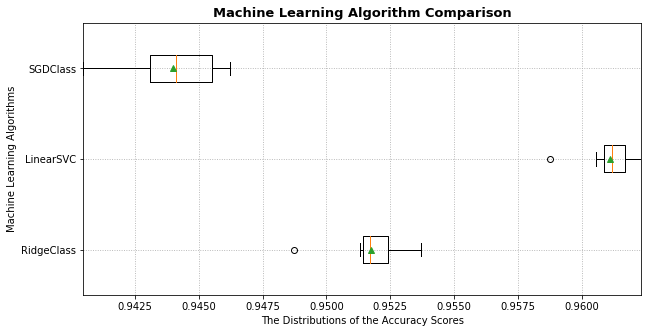

In [55]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
plt.boxplot(results,vert=False, showmeans=True) 
ax.set_yticklabels(names)
#for i,v in enumerate(cv_results.mean()):
 #   ax.text(v , i-0.15 , str(v), color='blue')#, fontweight='bold')
plt.autoscale(enable=True, axis='both',tight=True)
plt.grid(which='major',linestyle=':',linewidth=0.9)
plt.title('Machine Learning Algorithm Comparison', fontsize=13,fontweight='bold')
plt.ylabel('Machine Learning Algorithms', fontsize=10)
plt.xlabel('The Distributions of the Accuracy Scores', fontsize=10)
plt.show()

$$\textbf{Comments}$$
One can clearly see that the Linear Support Vector Classifier algorithm is the best one among three competing models. So, I choose this algorithm. However, it is worth noting that the configuration of three competing models is set at the default values. Thus, the performance of Linear Support Vector Classifier can be improved further by its hyperparameter tunning as follows. 

## Tunning Model

To this end, one might read the information about Linear Support Vector on the links below


1. Support Vector Machines 

https://scikit-learn.org/stable/modules/svm.html

2. LinearSVC

https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC

We need to tun two hyperparameters, such as penalty and C

### Preparing hyperparameters

In [76]:
print('The norm used in the penalization:')
penalty_values=['l1']#,'l2']
print(penalty_values)
print('Regularization parameter:')
c_values=np.arange(0.1,0.8,0.3)
print(c_values)
print('Combination:')
param_grid =dict(penalty=penalty_values,C=c_values)
print(param_grid)

The norm used in the penalization:
['l1']
Regularization parameter:
[0.1 0.4 0.7]
Combination:
{'penalty': ['l1'], 'C': array([0.1, 0.4, 0.7])}


### Defining model

In [77]:
tuning_model = LinearSVC(dual=False)
tuning_model

LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

### Tunning model
using 10 folds

In [82]:
kfold = KFold(n_splits=10, random_state=1)
t0 = time()
grid = GridSearchCV(estimator=tuning_model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(x_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print("done in %fs" % (time() - t0))

Best: 0.961804 using {'C': 0.7000000000000001, 'penalty': 'l1'}
0.957060 (0.001310) with: {'C': 0.1, 'penalty': 'l1'}
0.961334 (0.001344) with: {'C': 0.4, 'penalty': 'l1'}
0.961804 (0.001273) with: {'C': 0.7000000000000001, 'penalty': 'l1'}
done in 179.251788s


## Re-configuring model

In [80]:
mymodel=LinearSVC(penalty= 'l1',C= 0.7,dual=False)

# Creating the submission file.

In [ ]:
submid = pd.DataFrame({'id': subm["id"]})
submission = pd.concat([submid, pd.DataFrame(preds, columns = label_cols)], axis=1)
submission.to_csv('submission.csv', index=False)